# Preparations

In [1]:
import sys
import math
import copy
import itertools
import numpy as np
import collections

import scipy.stats
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.mlab import griddata

from sklearn.preprocessing import StandardScaler

sys.path.append('..')
from higgs_inference.various.utils import interpolate, format_number, asymptotic_p_value
from higgs_inference import settings


# Settings

In [16]:
# Interpolation in final plot.
interpolation_method = 'gp' #'linear'

# Which benchmark point to use
use_not_trained_benchmark = True

# Which algorithm to use for the PbP vs parameterized vs morphing-aware plot
use_regression_as_pbp_param_aware_example = False

# More plots
neyman_plots = False

In [17]:
#colors     = ['black', '0.7', 'red',  'c',    'green', 'mediumblue', 'darkorange', 'mediumblue', 'red', 'darkorange' ]
colors     = ['black', '0.65', '#CC002E',  'c',    'mediumblue', 'darkgreen', 'orange', 'orange', '#CC002E', 'mediumblue']

#linestyles = [  '-',     ':',   '--',   '-.',    ':',      '--',          '-.',        '-',         '--',  ':']
linestyles = [  '-',     ':',   '--',   '-.',    ':',      '-.',          '--',        '-',         '--',  ':']

linewidths = [  1.5,     2.,    1.5,     1.5,    2.,       1.5,            1.5,         1.5,          1.5,  2]

scatter_alpha = 1.

def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb

#for color in colors:
#    print(color, matplotlib.colors.to_rgb(color))

In [18]:
thetas = np.load('../data/thetas/thetas_parameterized.npy')

n_thetas = len(thetas)
theta1 = 708
theta_observed = 0
thetas_train = list(range(17,1017))
thetas_test = list(range(17))

if use_not_trained_benchmark:
    theta_benchmark = 9
    benchmark_name = 'nottrained'
else:
    theta_benchmark = 422
    benchmark_name = 'trained'
    
pbp_training_thetas = [0, 13, 14, 15, 16, 9, 422, 956, 666, 802, 675, 839, 699, 820, 203, 291, 634, 371, 973, 742, 901, 181, 82, 937, 510, 919, 745, 588, 804, 963, 396, 62, 401, 925, 874, 770, 108, 179, 669, 758, 113, 587, 600, 975, 496, 66, 467, 412, 701, 986, 598, 810, 97, 18, 723, 159, 320, 301, 352, 159, 89, 421, 574, 923, 849, 299, 119, 167, 939, 402, 52, 787, 978, 41, 873, 533, 827, 304, 294, 760, 890, 539, 1000, 291, 740, 276, 679, 167, 125, 429, 149, 430, 720, 123, 908, 256, 777, 809, 269, 851]
basis_thetas = [0, 101, 106, 902, 910,
                226, 373, 583, 747, 841,
                599, 709, 422, 367, 167]
thetas_highlighted = []

print(thetas[theta1])
print(thetas[theta_benchmark])

X_observed = np.load('../data/unweighted_events/X_test.npy')

[0.39293227 0.43229216]
[-0.5 -0.5]


In [19]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_sep_absolute = 8. * 0.02
margin_t_absolute = 8. * 0.02
margin_b_absolute = 8. * 0.08

def calculate_height(n_panels=2, width=8.):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width # Square plots
    height = n_panels_v * (panel_height_absolute + margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Return height
    return height


def adjust_margins(n_panels=2, width=8.):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width # Square plots
    height = n_panels_v * (panel_height_absolute + margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Set margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace)
    
#print(calculate_height(2,8.))
#print(calculate_height(3,8.))
#print(calculate_height((2,2),8.))

# Define strategies and load results

In [20]:
def _load(name, folder='parameterized'):
    return np.load('../results/' + folder + '/' + name + '.npy')

def add_strategy(label, suffix, folder,
                 neyman_suffix=None,
                 panel=-1, in_pbp_param_aware_plot=False, in_main_plot=True, is_truth=False,
                 zorder=None):
    
    try:
        _expected_llr = _load('llr_' + suffix, folder)
        
        _r_benchmark = _load('r_' + benchmark_name + '_' + suffix, folder)
            
    except IOError:
        print('Results for strategy ' + label + ' not found')
        return
    
    try:
        _mse_log_r = _load('mse_logr_' + suffix, folder)
        _trimmed_mse_log_r = _load('trimmed_mse_logr_' + suffix, folder)
        do_mse_log_r = True
    except IOError:
        _mse_log_r = None
        _trimmed_mse_log_r = None
        do_mse_log_r = False
    
    try:
        if neyman_suffix is None:
            _p_values = _load('p_values_' + suffix, folder)
            _q_thresholds = _load('neyman_qcut_' + suffix, folder)
            _q_threshold_uncertainties = _load('neyman_qcut_uncertainties_' + suffix, folder)
            _q_medians = _load('neyman_qmedian_' + suffix, folder)
        else:
            _p_values = _load('p_values_' + neyman_suffix, folder)
            _q_thresholds = _load('neyman_qcut_' + neyman_suffix, folder)
            _q_threshold_uncertainties = _load('neyman_qcut_uncertainties_' + neyman_suffix, folder)
            _q_medians = _load('neyman_qmedian_' + neyman_suffix, folder)
        do_neyman = True
        
        assert not np.all(np.isnan(_q_thresholds)), 'q thresholds contain only NaNs'
        assert not np.all(np.isnan(_q_medians)), 'q medians contain only NaNs'
        assert not np.all(np.isnan(_q_threshold_uncertainties)), 'q threshold uncertainties contain only NaNs'
        
    except IOError:
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        do_neyman = False
        
    except AssertionError as err:
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        do_neyman = False
    
    try:
        _r_roam = _load('r_roam_' + suffix, folder)
        do_roaming = True
    except IOError:
        _r_roam = None
        do_roaming = False
        
    labels.append(label)
    suffices.append(suffix)
    
    expected_llr.append(_expected_llr)
    mse_log_r.append(_mse_log_r)
    trimmed_mse_log_r.append(_trimmed_mse_log_r)
    p_values.append(_p_values)
    q_medians.append(_q_medians)
    q_threshold_uncertainties.append(_q_threshold_uncertainties)
    q_thresholds.append(_q_thresholds)
    
    r_benchmark.append(_r_benchmark)
    r_roam.append(_r_roam)
    
    index = len(labels) - 1
    if is_truth:
        truth_index = index
    if panel >= 0 and panel < 3:
        panel_indices[panel].append(index)
    in_pbp_param_aware_plots.append(in_pbp_param_aware_plot)
    in_main_plots.append(in_main_plot)
    
    zorders.append(zorder)
        
    if do_neyman or do_roaming:
        supported = []
        if do_neyman:
            supported.append('Neyman construction')
        if do_roaming:
            supported.append('theta dependence plots')
        supported = ', '.join(supported)
            
        print('Loaded strategy ' + label + ' with support for ' + supported)
        
    else:
        print('Loaded strategy ' + label)
    

In [21]:
labels = []
suffices = []
folders = []

truth_index = 0
panel_indices = ([], [])
panel_indices = ([], [], [])
in_pbp_param_aware_plots = []
in_main_plots = []

expected_llr = []
mse_log_r = []
trimmed_mse_log_r = []
p_values = []
q_medians = []
q_thresholds = []
q_threshold_uncertainties = []

r_benchmark = []
r_roam = []

zorders = []

add_strategy('Truth', 'truth', 'truth', is_truth=True)

add_strategy('Histogram', 'histo_2d_smeared_new', 'histo', panel=0)
add_strategy('carl', 'carl_calibrated_shallow_smeared_new', 'parameterized', panel=0, neyman_suffix='carl_shallow_new')
add_strategy('Local score regr.', 'scoreregression_score_deep_smeared_new', 'score_regression', panel=1)
add_strategy('Ratio regr.', 'regression_calibrated_smeared_new', 'parameterized', panel=1, neyman_suffix='regression_new')
add_strategy('carl + score regr.', 'combined_calibrated_deep_smeared_new', 'parameterized', panel=2, neyman_suffix='combined_deep_new')
add_strategy('Ratio + score regr.', 'combinedregression_calibrated_smeared', 'parameterized', panel=2, neyman_suffix='combinedregression_deep_new')

n_strategies = len(labels)

Loaded strategy Truth with support for Neyman construction, theta dependence plots
Loaded strategy Histogram
Loaded strategy carl with support for Neyman construction, theta dependence plots
Loaded strategy Local score regr.
Loaded strategy Ratio regr. with support for Neyman construction, theta dependence plots
Loaded strategy carl + score regr. with support for Neyman construction, theta dependence plots
Loaded strategy Ratio + score regr. with support for Neyman construction, theta dependence plots


# Interpolate LLR and p values

In [22]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

# interpolate
interpolated_p_values = []
interpolated_expected_llr = []
interpolated_expected_llr_mle = []

for p_vals, llr in zip(p_values, expected_llr):
    
    _llr, _mle = interpolate(thetas, llr, xx, yy, method=interpolation_method, subtract_min=False)
    if p_vals is not None:
        _p_vals, _ = interpolate(thetas, np.log(np.clip(p_vals,1.e-6, 1.)), xx, yy, method=interpolation_method)
        _p_vals = np.exp(_p_vals)
    else:
        _p_vals = None
    
    # Subtract SM value
    _llr -= llr[settings.theta_observed]
    
    interpolated_p_values.append(_p_vals)
    interpolated_expected_llr.append(_llr)
    interpolated_expected_llr_mle.append(_mle)
    
    
    
if neyman_plots:
    interpolated_q_medians = []
    interpolated_q_thresholds = []
    interpolated_95cl_excluded = []

    for qmed, qthresh, qthresh_err in zip(q_medians, q_thresholds, q_threshold_uncertainties):

        if qmed is None or qthresh is None or qthresh_err is None:
            interpolated_q_medians.append(None)
            interpolated_q_thresholds.append(None)
            interpolated_95cl_excluded.append(None)
            continue

        try:
            cut = (np.isfinite(qthresh)) & (np.isfinite(qmed)) & (np.isfinite(qthresh_err))
            _qthresh, _ = interpolate(thetas[cut], qthresh[cut], xx, yy, z_uncertainties_thetas=2*qthresh_err[cut],
                                      method='gp',
                                      length_scale_default=1., length_scale_min=0.5, length_scale_max=2.,
                                      matern_exponent=2.5,
                                      noise_level=0.01)
            _qmed, _ = interpolate(thetas[cut], qmed[cut], xx, yy,
                                      method='gp',
                                      length_scale_default=0.1, length_scale_min=0.01, length_scale_max=1.,
                                      matern_exponent=2.5,
                                      noise_level=0.01)

            _excluded = _qmed - _qthresh

            interpolated_q_medians.append(_qmed)
            interpolated_q_thresholds.append(_qthresh)
            interpolated_95cl_excluded.append(_excluded)

        except ValueError as err:
            print(err)
            interpolated_q_medians.append(None)
            interpolated_q_thresholds.append(None)
            interpolated_95cl_excluded.append(None)

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.76216554e-05, -6.02487760e-06,  1.42844834e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 22, 'warnflag': 2}
  " state: %s" % convergence_dict)


# Calculate p values from Asimov data

In [23]:
interpolated_p_values_asymptotics = []

for llrs in interpolated_expected_llr:
    pvals = [] 

    for llr in llrs.flatten():
        pvals.append(asymptotic_p_value(llr))

    pvals = np.asarray(pvals)
    pvals = pvals.reshape(llrs.shape)
    interpolated_p_values_asymptotics.append(pvals)


# Benchmark theta: approximate r(x) cs r(x,z)

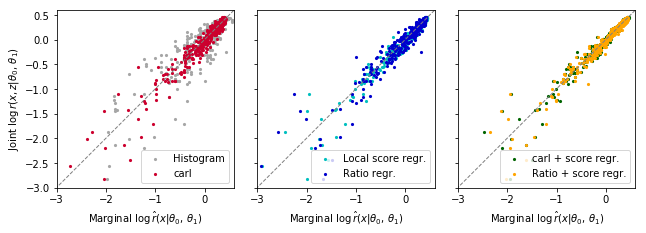

In [24]:
xmin, xmax = -3., 0.6
skip = 100

fig = plt.figure(figsize=(9., calculate_height(3,9.)))

for panel in range(3):
    
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)

    plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
    
    for i, s in enumerate(panel_indices[panel]):
        plt.scatter(np.log(r_benchmark[s][::skip]),
                    np.log(r_benchmark[truth_index][::skip]),
                    marker='o', alpha=1., s=10., c=colors[s], lw=0.,
                    label=labels[s])
        
    plt.legend(loc='lower right')
    
    plt.xlim(xmin,xmax)
    plt.ylim(xmin,xmax)
    plt.xlabel(r"Marginal $\log \, \hat{r}(x| \theta_0,\,\theta_1)$")
    if panel == 0:
        plt.ylabel(r"Joint $\log \, r(x,z| \theta_0,\,\theta_1)$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/paper/r_scatter_smearing.pdf")

# CL contours from asymptotics (expected LLR contours)

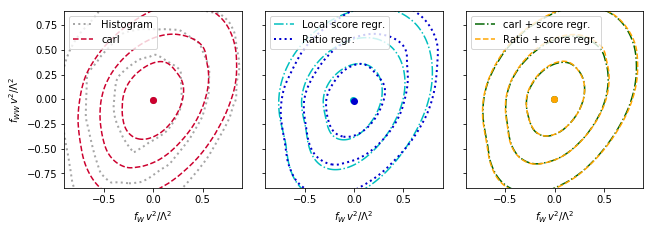

In [25]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

#llr_lines = [1.,4.,9.]
p_value_lines = [0.003,0.05,0.32]

fig = plt.figure(figsize=(9.,calculate_height(3,9.)))

for panel in range(3):
    
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)
        
    #cs = plt.contour(xi, yi, interpolated_p_values_asymptotics[truth_index], p_value_lines,
    #                 linewidths=linewidths[truth_index], colors=colors[truth_index],
    #                 linestyles=linestyles[truth_index])
    #cs.collections[0].set_label(labels[truth_index])
        
    for s in panel_indices[panel]:
        cs = plt.contour(xi, yi, interpolated_p_values_asymptotics[s], p_value_lines,
                         linewidths=linewidths[s], colors=colors[s],
                         linestyles=linestyles[s])
        cs.collections[0].set_label(labels[s])

    #plt.scatter([xi[interpolated_expected_llr_mle[truth_index][1]]],
    #            [yi[interpolated_expected_llr_mle[truth_index][0]]],
    #            marker='o', c=colors[truth_index], s=50, lw=0, zorder=10)
        
    for s in panel_indices[panel]:
        plt.scatter([xi[interpolated_expected_llr_mle[s][1]]],
                    [yi[interpolated_expected_llr_mle[s][0]]],
                    marker='o', c=colors[s], s=50, lw=0, zorder=10)

    plt.legend(loc='upper left')

    plt.xlim(-0.9, 0.9)
    plt.ylim(-0.9, 0.9)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    if panel==0:
        plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/paper/cl_contours_asymptotics_smearing.pdf")

# CL contours from Neyman construction

In [26]:
if neyman_plots:
    fig = plt.figure(figsize=(9.,calculate_height(3,9.)))

    for panel in range(3):

        if panel == 0:
            ax0 = plt.subplot(1, 3, panel+1)
        else:
            ax = plt.subplot(1, 3, panel+1, sharey=ax0)

        cs = plt.contour(xi, yi, interpolated_q_medians[truth_index], [settings.q_threshold],
                         linewidths=1.5, colors='darkgreen',
                         linestyles='--')
        cs.collections[0].set_label('Truth (asymptotics)')

        cs = plt.contour(xi, yi, interpolated_95cl_excluded[truth_index], [0.],
                         linewidths=1.5, colors=colors[truth_index],
                         linestyles=linestyles[truth_index])
        cs.collections[0].set_label(labels[truth_index])

        for s in panel_indices[panel]:
            if interpolated_p_values[s] is None:
                continue

            cs = plt.contour(xi, yi, interpolated_95cl_excluded[s], [0.],
                             linewidths=linewidths[s], colors=colors[s],
                             linestyles=linestyles[s])
            cs.collections[0].set_label(labels[s])

        plt.legend(loc='upper left')

        plt.xlim(-0.5, 0.5)
        plt.ylim(-0.5, 0.5)
        plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
        if panel==0:
            plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
        else:
            plt.setp(ax.get_yticklabels(), visible=False)

    adjust_margins(3,9.)
    plt.savefig("../figures/paper/cl_contours_nc.pdf")